### Переходим к практике

In [3]:
!pip install razdel

In [4]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 8.2MB 11.2MB/s 


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

Наши новости

In [8]:
news = pd.read_csv('/content/drive/MyDrive/Notebooks/ML_in_business/2/lection2_materials/articles.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [9]:
users = pd.read_csv("/content/drive/MyDrive/Notebooks/ML_in_business/2/lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [10]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [13]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [14]:
with open('/content/drive/MyDrive/Notebooks/ML_in_business/2/lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [16]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 19.5 s, sys: 953 ms, total: 20.4 s
Wall time: 20.5 s


In [17]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 20s, sys: 147 ms, total: 3min 20s
Wall time: 3min 21s


А теперь в 3 строчки обучим нашу модель

In [18]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [19]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [20]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 51.5 s, sys: 24.5 s, total: 1min 16s
Wall time: 48.4 s


In [21]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [22]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.7836206), (22, 0.0822211), (23, 0.11269487)]

In [23]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: всё очень первый статья наука научный проблема
topic_1: ракета население российский технология запуск министерство россия
topic_2: доллар рак курс писать метод долг болезнь
topic_3: рост цена газ объём вырасти доход нефть
topic_4: банк гражданин ребёнок решение документ депутат право
topic_5: военный россия действие российский закон безопасность nn
topic_6: турист взрыв улица произойти теракт площадь столица
topic_7: самолёт космический территория корабль сша полёт млрд
topic_8: украина украинский уголовный преступление киев признать обвинение
topic_9: система рынок новый эксперт экономика снижение иметь
topic_10: фонд пенсия обращение прожиточный вич святой возраст
topic_11: проект область станция банк земля директор москва
topic_12: nn земля тело мужчина место установить женщина
topic_13: россия российский глава государство путин правительство министр
topic_14: журнал исследователь статья автор поверхность университет ран
topic_15: млн составить тыс общий составлять место по

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [24]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [25]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.020893,0.000000,0.914911,0.0,0.0,0.0,0.000000,0.037855,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.019283
1,4896,0.124669,0.0,0.0,0.0,0.0,0.0,0.590808,0.0,0.05983,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.204205
2,4897,0.783612,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.082225,0.112699,0.000000
3,4898,0.533733,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.364247,0.000000,0.000000,0.0,0.0,0.0,0.064436,0.000000,0.0,0.0,0.0,0.0,0.027583,0.000000,0.000000,0.000000
4,4899,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.062139,0.912996,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [26]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [27]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [28]:
doc_dict[293622]

array([0.02547005, 0.04839457, 0.        , 0.        , 0.14019765,
       0.        , 0.        , 0.0170087 , 0.04063927, 0.        ,
       0.05724655, 0.01442727, 0.        , 0.05400291, 0.        ,
       0.        , 0.        , 0.14958201, 0.04278425, 0.31760371,
       0.03566117, 0.        , 0.        , 0.05182061, 0.        ])

In [29]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [30]:
get_user_embedding(user_articles_list)

array([0.02857794, 0.02988049, 0.        , 0.        , 0.        ,
       0.10035353, 0.        , 0.        , 0.        , 0.08864804,
       0.        , 0.00603824, 0.        , 0.07346082, 0.01904545,
       0.        , 0.        , 0.        , 0.00865277, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [31]:
#users['articles'].iloc[33]

In [32]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [33]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.033841,0.000000,0.028540,0.00000,0.020555,0.000000,0.000000,0.000000,0.038545,0.016395,0.000000,0.024687,0.000000,0.078205,0.000000,0.0,0.0,0.000000,0.010782,0.056162,0.017831,0.000000,0.014321,0.000000,0.0
1,u108690,0.139986,0.053572,0.008127,0.03348,0.064087,0.077056,0.000000,0.014052,0.105762,0.035436,0.015561,0.000000,0.006492,0.086195,0.021502,0.0,0.0,0.000000,0.009842,0.042004,0.018132,0.000000,0.000000,0.005696,0.0
2,u108339,0.062851,0.016598,0.025630,0.01051,0.057224,0.097867,0.056116,0.015027,0.028733,0.000000,0.000000,0.028862,0.168719,0.150919,0.019016,0.0,0.0,0.010314,0.000000,0.000000,0.023473,0.005489,0.000000,0.000000,0.0


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [34]:
target = pd.read_csv("/content/drive/MyDrive/Notebooks/ML_in_business/2/lection2_materials/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [35]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.033841,0.000000,0.028540,0.00000,0.020555,0.000000,0.000000,0.000000,0.038545,0.016395,0.000000,0.024687,0.000000,0.078205,0.000000,0.0,0.0,0.000000,0.010782,0.056162,0.017831,0.000000,0.014321,0.000000,0.0,0
1,u108690,0.139986,0.053572,0.008127,0.03348,0.064087,0.077056,0.000000,0.014052,0.105762,0.035436,0.015561,0.000000,0.006492,0.086195,0.021502,0.0,0.0,0.000000,0.009842,0.042004,0.018132,0.000000,0.000000,0.005696,0.0,1
2,u108339,0.062851,0.016598,0.025630,0.01051,0.057224,0.097867,0.056116,0.015027,0.028733,0.000000,0.000000,0.028862,0.168719,0.150919,0.019016,0.0,0.0,0.010314,0.000000,0.000000,0.023473,0.005489,0.000000,0.000000,0.0,1


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [38]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11089443, 0.04115746, 0.31457235, 0.1154761 , 0.09921954,
       0.06619007, 0.11919497, 0.08807084, 0.06061756, 0.17775498])

In [40]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.204701, F-Score=0.740, Precision=0.656, Recall=0.849


In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
import itertools

Confusion matrix, without normalization
[[1646  109]
 [  38  207]]


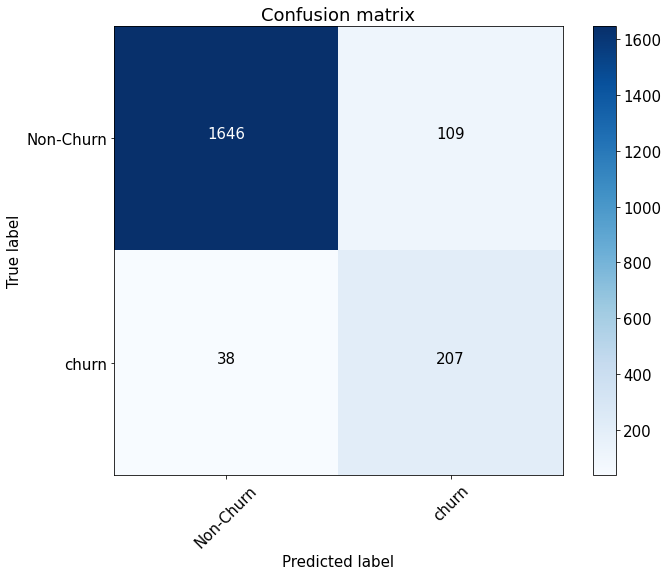

In [44]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [45]:
roc_auc_score(y_test, preds)

0.9648840048840049

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [46]:
# Добавим на вход аггрегирующую функцию
def get_user_embedding(user_articles_list, aggregation):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = aggregation(user_vector, 0)
    return user_vector

In [47]:
#Словарь с аггрегирующими функциями
aggregation = {'mean' : np.mean, 
               'median' : np.median,
               'max' : np.max}

 #Здесь будет наша таблица              
result = {'agg_func': [],
           'precision': [],
           'recall': [],
           'fscore':[], 
           'roc_auc':[]}

for agg_name, agg_func in aggregation.items():
  user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, agg_func), 1)])
  user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
  user_embeddings['uid'] = users['uid'].values
  user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

  X = pd.merge(user_embeddings, target, 'left')
  #разделим данные на train/test
  X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

  logreg.fit(X_train, y_train)

  preds = logreg.predict_proba(X_test)[:, 1]

  precision, recall, thresholds = precision_recall_curve(y_test, preds)
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)

  result['agg_func'].append(agg_name)
  result['precision'].append(precision[ix])
  result['recall'].append(recall[ix])
  result['fscore'].append(fscore[ix])
  result['roc_auc'].append(roc_auc_score(y_test, preds))

In [48]:
result = pd.DataFrame(result)
result

,agg_func,precision,recall,fscore,roc_auc
0,mean,0.574534,0.755102,0.652557,0.937785
1,median,0.656151,0.848980,0.740214,0.964884
2,max,0.756757,0.800000,0.777778,0.974724


#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk